In [1]:
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region_name = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region_name)

In [2]:
#Retrieving stores database
%store -r ingest_create_athena_db_passed

In [3]:
#Checking for returned database
print(ingest_create_athena_db_passed)

True


In [4]:
#Retrieving stores tables
%store -r ingest_create_athena_table_csv_passed

In [5]:
print(ingest_create_athena_table_csv_passed)

True


In [6]:
#Retrieving stored private s3 bucket
%store -r s3_private_path_csv_credit_card_trans
%store -r s3_private_path_csv_user_credit_card_trans
%store -r s3_private_path_csv_card_info
%store -r s3_private_path_csv_user_info

In [7]:
#Checking bucket is returned
print(s3_private_path_csv_credit_card_trans)
print(s3_private_path_csv_user_credit_card_trans)
print(s3_private_path_csv_card_info)
print(s3_private_path_csv_user_info)

s3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/credit_card_trans/
s3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/user_credit_card_trans/
s3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/card_info/
s3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/user_info/


In [8]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_directory = "s3://{0}/athena/staging".format(bucket)

In [9]:
import awswrangler as wr
df = wr.s3.read_csv(path='s3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/merge_df.csv')

In [10]:
import pandas as pd

In [11]:
df.head()

,Unnamed: 0,user,card,year,month,day,amount,use_chip,merchant_name,merchant_city,...,NO,YES,Chip Transaction,Online Transaction,Swipe Transaction,Female,Male,Credit,Debit,Debit (Prepaid)
0,0,1963,2,2013,12,2,88.09,Online Transaction,7145736684866660022,ONLINE,...,0,1,0,1,0,1,0,1,0,0
1,1,1963,2,2013,12,2,88.09,Online Transaction,7145736684866660022,ONLINE,...,0,1,0,1,0,1,0,0,1,0
2,2,1963,2,2013,12,2,88.09,Online Transaction,7145736684866660022,ONLINE,...,0,1,0,1,0,1,0,0,0,1
3,3,1963,2,2013,12,2,114.00,Online Transaction,1270471339275628505,ONLINE,...,0,1,0,1,0,1,0,1,0,0
4,4,1963,2,2013,12,2,114.00,Online Transaction,1270471339275628505,ONLINE,...,0,1,0,1,0,1,0,0,1,0


In [12]:
df.columns

Index(['Unnamed: 0', 'user', 'card', 'year', 'month', 'day', 'amount',
       'use_chip', 'merchant_name', 'merchant_city', 'merchant_state', 'zip',
       'mcc', 'errors', 'is_fraud', 'card_index', 'card_brand', 'card_type',
       'cvv', 'has_chip', 'cards_issued', 'credit_limit',
       'year_pin_last_changed', 'card_on_dark_web', 'person', 'current_age',
       'retirement_age', 'birth_year', 'birth_month', 'gender', 'address',
       'city', 'state', 'zipcode', 'latitude', 'longitude',
       'per_capita_income_zipcode', 'yearly_income_person', 'total_debt',
       'fico_score', 'num_credit_cards', 'hour', 'minutes',
       'acct_open_temp_month', 'acct_open_year', 'expires_temp_month',
       'expires_year', 'class', 'NO', 'YES', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'Female', 'Male', 'Credit',
       'Debit', 'Debit (Prepaid)'],
      dtype='object')

In [13]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [14]:
df

,user,card,year,month,day,amount,use_chip,merchant_name,merchant_city,merchant_state,...,NO,YES,Chip Transaction,Online Transaction,Swipe Transaction,Female,Male,Credit,Debit,Debit (Prepaid)
0,1963,2,2013,12,2,88.09,Online Transaction,7145736684866660022,ONLINE,NaN,...,0,1,0,1,0,1,0,1,0,0
1,1963,2,2013,12,2,88.09,Online Transaction,7145736684866660022,ONLINE,NaN,...,0,1,0,1,0,1,0,0,1,0
2,1963,2,2013,12,2,88.09,Online Transaction,7145736684866660022,ONLINE,NaN,...,0,1,0,1,0,1,0,0,0,1
3,1963,2,2013,12,2,114.00,Online Transaction,1270471339275628505,ONLINE,NaN,...,0,1,0,1,0,1,0,1,0,0
4,1963,2,2013,12,2,114.00,Online Transaction,1270471339275628505,ONLINE,NaN,...,0,1,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945440,1275,2,2010,4,4,9.64,Swipe Transaction,1799189980464955940,Brooklyn,NY,...,0,1,0,0,1,1,0,0,0,1
945441,1275,2,2010,4,4,140.00,Swipe Transaction,-4282466774399734331,Brooklyn,NY,...,0,1,0,0,1,1,0,0,0,1
945442,1275,2,2010,4,4,140.00,Swipe Transaction,-4282466774399734331,Brooklyn,NY,...,0,1,0,0,1,1,0,0,1,0
945443,1275,2,2010,4,4,140.00,Swipe Transaction,-4282466774399734331,Brooklyn,NY,...,0,1,0,0,1,1,0,0,1,0


In [15]:
df.shape

(945445, 57)

In [32]:
df = df.drop(['person','address','card_on_dark_web','use_chip','is_fraud',
                   'card_brand','card_type','has_chip','gender','merchant_name','merchant_city','merchant_state',
                  'state','zipcode', 'city'], axis = 1, inplace = True)

In [19]:
#!pip install imblearn

In [20]:
#The data is imbalance so we will perform undersample to resample our data for better use
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
us = RandomUnderSampler(random_state=0)
X_resampled, y_resamples = us.fit_resample(X,y)
print(sorted(Counter(y_resamples).items()), y_resamples.shape)

[(0, 123780), (1, 123780)] (247560,)


Algorithms to run
1. Random Forest
2. Logistic Regression
3. Neural Network
4. Knn
5. XGBoost 
6. SVM

In [21]:
from sklearn.model_selection import train_test_split

# In the first step we will split the data in training and remaining dataset
df_train, df_holdout = train_test_split(df, 
                                        test_size=0.20, 
                                        stratify=df['class'])

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
df_valid, df_test = train_test_split(df_holdout,
                                          test_size=0.50, 
                                          stratify=df_holdout['class'])


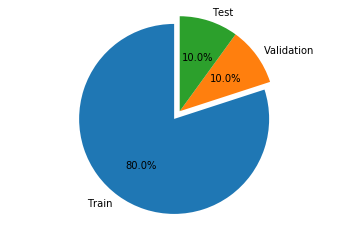

In [22]:
import matplotlib.pyplot as plt
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Train', 'Validation', 'Test']
sizes = [len(df_train.index), len(df_valid.index), len(df_test.index)]
explode = (0.1, 0, 0)  

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')  

plt.show()

### Uploading csv train file to s3

In [23]:
#writing train validation and testing csv to public s3.
import awswrangler as wr
wr.s3.to_csv(df=df_train, path='s3://finalproject-datasets/csv/model_dataset/train/train.csv')

{'paths': ['s3://finalproject-datasets/csv/model_dataset/train/train.csv'],
 'partitions_values': {}}

### Uploading csv validation file to s3

In [24]:
wr.s3.to_csv(df=df_valid, path='s3://finalproject-datasets/csv/model_dataset/validation/xvalid.csv')

{'paths': ['s3://finalproject-datasets/csv/model_dataset/validation/xvalid.csv'],
 'partitions_values': {}}

### Uploading csv test file to s3

In [25]:
wr.s3.to_csv(df=df_test, path='s3://finalproject-datasets/csv/model_dataset/test/xtest.csv')

{'paths': ['s3://finalproject-datasets/csv/model_dataset/test/xtest.csv'],
 'partitions_values': {}}

### Uploading csv files to private S3 bucket

In [26]:
#Train
wr.s3.to_csv(df=df_train, path='s3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/model_dataset/train/train.csv')
#Validation
wr.s3.to_csv(df=df_valid, path='s3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/model_dataset/validation/valid.csv')
#Test
wr.s3.to_csv(df=df_test, path='s3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/model_dataset/test/test.csv')

{'paths': ['s3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/model_dataset/test/test.csv'],
 'partitions_values': {}}

### Setting up AutoPilot Job

In [27]:
input_data_config = [{
      'DataSource': {
          'S3DataSource': {
              'S3DataType': 'S3Prefix',
              'S3Uri': 's3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/model_dataset/train'
          }
      },
       'TargetAttributeName': 'class'
}
]

output_data_config = {
    'S3OutputPath': 's3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/model_dataset/output'
}

### Launching the SageMaker Autopilot Job

In [30]:
from time import gmtime, strftime, sleep
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())

auto_ml_job_name = 'automl-credit-' + timestamp_suffix
print('AutoMLJobName: ' + auto_ml_job_name)

sm.create_auto_ml_job(AutoMLJobName=auto_ml_job_name,
                      InputDataConfig=input_data_config,
                     OutputDataConfig=output_data_config,
                     RoleArn=role)

AutoMLJobName: automl-credit-05-00-44-56


{'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:584771966647:automl-job/automl-credit-05-00-44-56',
 'ResponseMetadata': {'RequestId': '47e65efc-d5d4-46a5-b412-a0bf8f30da26',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '47e65efc-d5d4-46a5-b412-a0bf8f30da26',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '96',
   'date': 'Tue, 05 Apr 2022 00:44:58 GMT'},
  'RetryAttempts': 0}}

### Tracking SageMaker AutoPilot job progress

In [31]:
print('JobStatus - Secondary Status')
print('------------------------------')

describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print(describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
job_run_status = describe_response['AutoMLJobStatus']

while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response['AutoMLJobStatus']
    
    print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(30)

JobStatus - Secondary Status
------------------------------
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - Analyzing